In [1]:
import os

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [34]:
store_sales = pd.read_csv("/content/train.csv")
store_sales.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


first check null values

In [8]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


dropping store and item columns

In [9]:
store_sales = store_sales.drop(['store','item'],axis =1)

In [11]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


converting date to datetime datatype from object datatype

In [40]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [39]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


converting date to a month period and then sum the number of items in each month

In [41]:
store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()

converting the resulting date column to timestamp datatype

In [42]:
monthly_sales['date']= monthly_sales['date'].dt.to_timestamp()

In [43]:
monthly_sales.head(10)

,date,store,item,sales
0,2013-01-01,85250,395250,454904
1,2013-02-01,77000,357000,459417
2,2013-03-01,85250,395250,617382
3,2013-04-01,82500,382500,682274
4,2013-05-01,85250,395250,763242
5,2013-06-01,82500,382500,795597
6,2013-07-01,85250,395250,855922
7,2013-08-01,85250,395250,766761
8,2013-09-01,82500,382500,689907
9,2013-10-01,85250,395250,656587


visualize

In [45]:
monthly_sales.tail()

,date,store,item,sales
55,2017-08-01,85250,395250,1026403
56,2017-09-01,82500,382500,935263
57,2017-10-01,85250,395250,891160
58,2017-11-01,82500,382500,928837
59,2017-12-01,85250,395250,695170


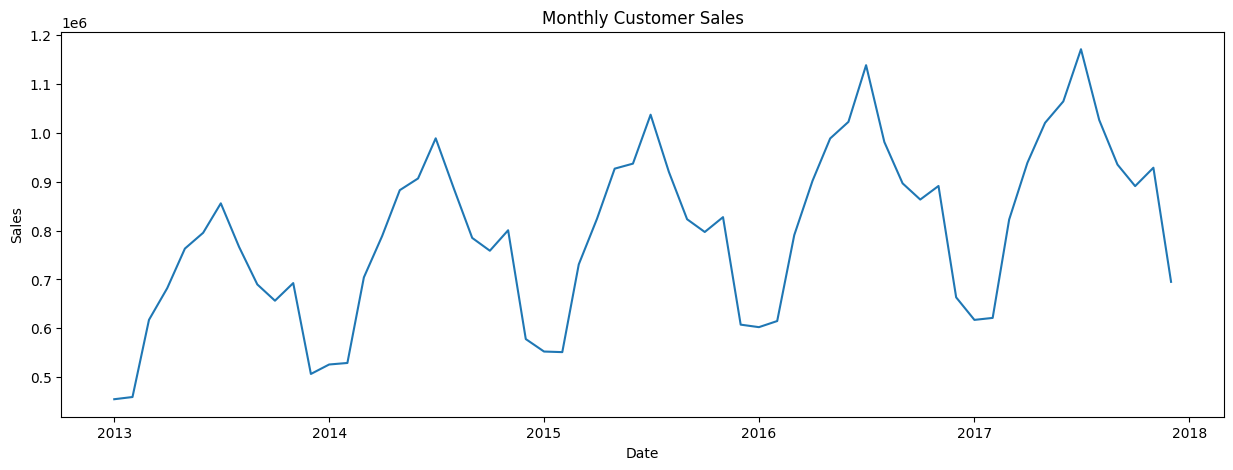

In [44]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel ("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales")
plt.show()


call the difference on the sales columns to make the sales data stationary


In [49]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,store,item,sales,sales_diff
1,2013-02-01,77000,357000,459417,4513.0
2,2013-03-01,85250,395250,617382,157965.0
3,2013-04-01,82500,382500,682274,64892.0
4,2013-05-01,85250,395250,763242,80968.0
5,2013-06-01,82500,382500,795597,32355.0
6,2013-07-01,85250,395250,855922,60325.0
7,2013-08-01,85250,395250,766761,-89161.0
8,2013-09-01,82500,382500,689907,-76854.0
9,2013-10-01,85250,395250,656587,-33320.0
10,2013-11-01,82500,382500,692643,36056.0


In [50]:
monthly_sales = monthly_sales.drop(['store','item'],axis =1)

In [51]:
monthly_sales.tail()

,date,sales,sales_diff
55,2017-08-01,1026403,-144990.0
56,2017-09-01,935263,-91140.0
57,2017-10-01,891160,-44103.0
58,2017-11-01,928837,37677.0
59,2017-12-01,695170,-233667.0


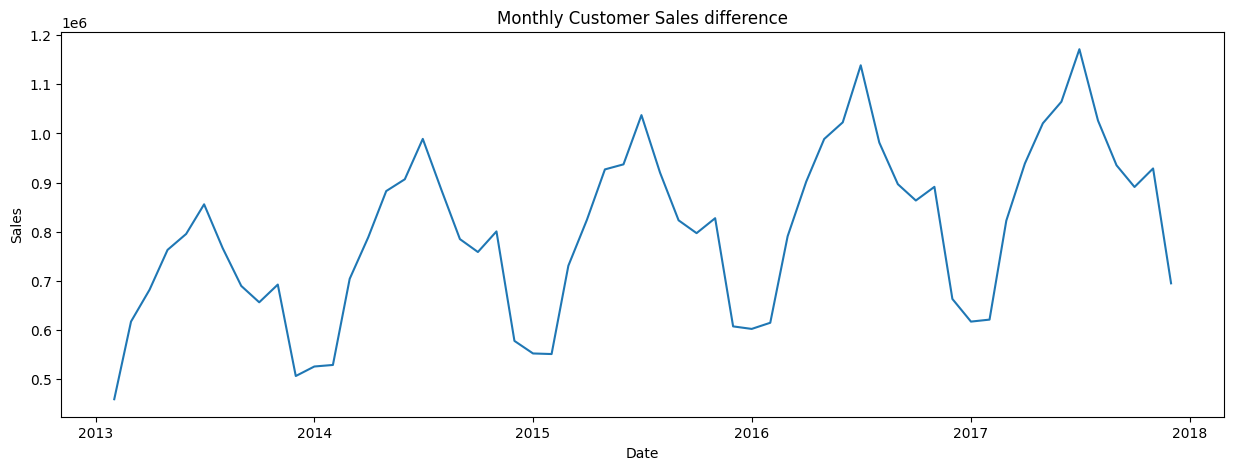

In [52]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel ("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales difference")
plt.show()

dropping off sales and date and creating supervised data

In [53]:
supervised_data = monthly_sales.drop(['date','sales'], axis=1)

In [56]:
for i in range (1,13):
 col_name = 'month_' + str(i)
 supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)  # now we get the sales dif for each store based on each month

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0
1,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0
2,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0
3,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0
4,10282.0,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0
5,100166.0,10282.0,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0,82168.0
6,-116949.0,100166.0,10282.0,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0,-103414.0
7,-97069.0,-116949.0,100166.0,10282.0,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0,-100472.0
8,-26079.0,-97069.0,-116949.0,100166.0,10282.0,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0,-26241.0
9,30392.0,-26079.0,-97069.0,-116949.0,100166.0,10282.0,102435.0,93516.0,179634.0,-1196.0,-25535.0,-222735.0,41900.0


spilt data into train and test

In [58]:
train_data = supervised_data[:-12]  # for previous 12 months
test_data = supervised_data[-12:]  # for coming 12 months
print("Train Data Shape: ",train_data.shape)
print("Test Data Shape: ",test_data.shape)


Train Data Shape:  (23, 13)
Test Data Shape:  (12, 13)


In [63]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [69]:
x_train,y_train,= train_data[:1,1:],train_data[:,0:1]
x_test ,y_test = test_data[:,1:],test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("X_train shape: ",x_train.shape)
print("Y_train shape: ",y_train.shape)
print("X_test shape: ",x_test.shape)
print("Y_test shape: ",y_test.shape)

X_train shape:  (1, 12)
Y_train shape:  (23,)
X_test shape:  (12, 12)
Y_test shape:  (12,)
